In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.neo4j_vector import Neo4jVector
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from getpass import getpass
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder, HumanMessagePromptTemplate, PromptTemplate
from langchain import hub
from langchain_openai import ChatOpenAI
from graphdatascience import GraphDataScience
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

/Users/nathansmith/anaconda3/envs/chatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up connection information

In [3]:
openai_api_key = getpass()

 ········


In [4]:
neo4j_password = getpass()

 ········


In [5]:
neo4j_uri = "neo4j+s://2fe3bf28.databases.neo4j.io"
neo4j_user = "neo4j"

In [6]:
gds = GraphDataScience(neo4j_uri, auth=(neo4j_user, neo4j_password))

# Set up queries against different vector indexes

In [7]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key=openai_api_key)

def query_movies(query_string, query_vector, query_type):
    queries = {
        "movie": """CALL db.index.vector.queryNodes("movie_text_vectors", 50, $query_vector) YIELD node, score 
                    RETURN $queryString AS query,
                    "movie" AS index,
                    score, node.tmdbId AS tmdbId, node.title AS title, node.overview AS overview, 
                    node{question: $queryString, .title, .overview} AS map
                    ORDER BY score DESC""",
        "theme": """CALL db.index.vector.queryNodes("theme_vectors", 50, $query_vector) YIELD node, score
                    MATCH (node)<-[:HAS_THEME]-(m)
                    RETURN $queryString AS query,
                    "theme" AS index,
                    collect(node.description) AS theme, 
                    gds.similarity.cosine(m.embedding, $query_vector) AS score, 
                    m.tmdbId AS tmdbId, m.title AS title, m.overview AS overview,
                    m{question: $queryString, .title, .overview} AS map
                    ORDER BY score DESC, gds.similarity.cosine(m.embedding, $query_vector) DESC
                    LIMIT 50
                    """,
        "theme_group_short": """CALL db.index.vector.queryNodes("theme_group_summary_vectors", 25, $query_vector) YIELD node, score
                          MATCH (node)<-[:IN_GROUP]-()<-[:HAS_THEME]-(m)
                          RETURN $queryString AS query,
                          "theme_group_short" AS index,
                          collect(node.descriptions) AS theme,
                          gds.similarity.cosine(m.embedding, $query_vector) AS score, 
                          m.tmdbId AS tmdbId, m.title AS title, m.overview AS overview,
                          m{question: $queryString, .title, .overview} AS map
                          ORDER BY score DESC, gds.similarity.cosine(m.embedding, $query_vector) DESC
                          LIMIT 50""",
        "theme_group_long": """CALL db.index.vector.queryNodes("theme_group_long_summary_vectors", 25, $query_vector) YIELD node, score
                          MATCH (node)<-[:IN_GROUP]-()<-[:HAS_THEME]-(m)
                          RETURN $queryString AS query,
                          "theme_group_long" AS index,
                          collect(node.descriptions) AS theme,
                          gds.similarity.cosine(m.embedding, $query_vector) AS score, 
                          m.tmdbId AS tmdbId, m.title AS title, m.overview AS overview,
                          m{question: $queryString, .title, .overview} AS map
                          ORDER BY score DESC, gds.similarity.cosine(m.embedding, $query_vector) DESC
                          LIMIT 50""",

        "theme_group_mean": """CALL db.index.vector.queryNodes("theme_group_mean_vectors", 25, $query_vector) YIELD node, score
                               MATCH (node)<-[:IN_GROUP]-()<-[:HAS_THEME]-(m)
                               RETURN $queryString AS query,
                               "theme_group_mean" AS index,
                               collect(node.descriptions) AS theme,
                               gds.similarity.cosine(m.embedding, $query_vector) AS score, 
                               m.tmdbId AS tmdbId, m.title AS title, m.overview AS overview,
                               m{question: $queryString, .title, .overview} AS map
                               ORDER BY score DESC, gds.similarity.cosine(m.embedding, $query_vector) DESC
                               LIMIT 50"""
    }
        
    movie_df = gds.run_cypher(queries[query_type], {"queryString": query_string, "query_vector": query_vector, "token":openai_api_key})
    return movie_df

# Ask LLM to determine if the movie returned matches the query

In [8]:
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a movie expert providing information about movies.
                  You will be given a question and information about the title and overview of a movie.
                  Decide whether the movie should be returned as an answer to the question.
                  If the movie matches theme of the question, return "yes".
                  If the movie does not match the theme of the question, return "no".
                    """),
    ("user", """<question>{question}</question>
    <title>{title}</movie>
    <overview>{overview}</overview>"""),
])
chat = ChatOpenAI(temperature=0, openai_api_key=openai_api_key, model="gpt-3.5-turbo")
chain = prompt | chat

# Run queries against each index and collect results

In [10]:
def compare_retrievers(query):
    query_vector = embeddings.embed_query(query)

    movie_df = query_movies(query, query_vector, "movie")
    theme_df = query_movies(query, query_vector, "theme")
    theme_group_short_df = query_movies(query, query_vector, "theme_group_short")
    theme_group_long_df = query_movies(query, query_vector, "theme_group_long")
    theme_group_mean_df = query_movies(query, query_vector, "theme_group_mean")
    
    concat_df = pd.concat([movie_df, 
                           theme_df.drop("theme", axis=1), 
                           theme_group_short_df.drop("theme", axis=1), 
                           theme_group_long_df.drop("theme", axis=1), 
                           theme_group_mean_df.drop("theme", axis=1)])
    concat_df.drop_duplicates(subset="tmdbId", inplace=True)
    
    concat_df['matches_theme'] = [message.content for message in chain.batch(concat_df['map'].tolist())]
    concat_df.drop(labels=["score", "map", "index"], axis=1, inplace=True)
    concat_df['query'] = query
    
    movie_df = movie_df.merge(concat_df[['tmdbId', 'matches_theme']], how="inner", on="tmdbId")
    theme_df = theme_df.merge(concat_df[['tmdbId', 'matches_theme']], how="inner", on="tmdbId")
    theme_group_short_df = theme_group_short_df.merge(concat_df[['tmdbId', 'matches_theme']], how="left", on="tmdbId")
    theme_group_long_df = theme_group_long_df.merge(concat_df[['tmdbId', 'matches_theme']], how="left", on="tmdbId")
    theme_group_mean_df = theme_group_mean_df.merge(concat_df[['tmdbId', 'matches_theme']], how="inner", on="tmdbId")
    
    #Shuffle concat_df so you aren't biased when doing the human rakings
    concat_df = concat_df.sample(frac = 1)

    stats_df = pd.DataFrame({
         "query": query,
         "movie_total_records": movie_df['matches_theme'].count(), 
         "movie_matched_records": movie_df['matches_theme'].value_counts().get('yes', 0),
         "movie_percent_matched": movie_df['matches_theme'].value_counts().get('yes', 0)/movie_df['matches_theme'].count(),
         "theme_total_records": theme_df['matches_theme'].count(), 
         "theme_matched_records": theme_df['matches_theme'].value_counts().get('yes', 0),
         "theme_percent_matched": theme_df['matches_theme'].value_counts().get('yes', 0)/theme_df['matches_theme'].count(),
         "theme_group_short_total_records": theme_group_short_df['matches_theme'].count(), 
         "theme_group_short_matched_records": theme_group_short_df['matches_theme'].value_counts().get('yes', 0),
         "theme_group_short_percent_matched": theme_group_short_df['matches_theme'].value_counts().get('yes', 0)/theme_group_short_df['matches_theme'].count(),
         "theme_group_long_total_records": theme_group_long_df['matches_theme'].count(), 
         "theme_group_long_matched_records": theme_group_long_df['matches_theme'].value_counts().get('yes', 0),
         "theme_group_long_percent_matched": theme_group_long_df['matches_theme'].value_counts().get('yes', 0)/theme_group_long_df['matches_theme'].count(),
         "theme_group_mean_total_records": theme_group_mean_df['matches_theme'].count(), 
         "theme_group_mean_matched_records": theme_group_mean_df['matches_theme'].value_counts().get('yes', 0),
         "theme_group_mean_percent_matched": theme_group_mean_df['matches_theme'].value_counts().get('yes', 0)/theme_group_mean_df['matches_theme'].count(),
    },
        index=[0])
    
    return movie_df, theme_df, theme_group_short_df, theme_group_long_df, theme_group_mean_df, stats_df, concat_df

# Gather results for multiple different queries

In [11]:
movie_dfs = []
theme_dfs = []
theme_group_short_dfs = []
theme_group_long_dfs = []
theme_group_mean_dfs = []
stats_dfs = []
concat_dfs = []

queries = ['documentary about a painter',
           'classical music',
           'ice hockey', 
           'baseball',
           'who-done-it',
           'dark comedy',
           'Europe in the 1960s',
           'precolumbian America', 
           'birds',
           'dogs',
]

long_queries = {
    'What are some documentaries about painters?' :'documentary about a painter',
    'What are some movies about classical music?': 'classical music',
    'What are some movies about ice hockey?': 'ice hockey', 
    'What are some movies about baseball?': 'baseball',
    'What are some who-done-it movies?': 'who-done-it',
    'What are some dark comedies?': 'dark comedy',
    'What are some movies set in Europe in the 1960s?': 'Europe in the 1960s',
    'What are some movies about pre-Columbian America?': 'precolumbian America', 
    'What are some movies about birds?': 'birds',
    'What are some movies about dogs?': 'dogs'}

for query in long_queries.keys():
    movie_df, theme_df, theme_group_short_df, theme_group_long_df, theme_group_mean_df, stats_df, concat_df = compare_retrievers(query)
    movie_dfs.append(movie_df)
    theme_dfs.append(theme_df)
    theme_group_short_dfs.append(theme_group_short_df)
    theme_group_long_dfs.append(theme_group_long_df)
    theme_group_mean_dfs.append(theme_group_mean_df)
    stats_dfs.append(stats_df)
    concat_dfs.append(concat_df)
    print(f"Completed: {query}")

Completed: What are some documentaries about painters?


Completed: What are some movies about classical music?


Completed: What are some movies about ice hockey?


Completed: What are some movies about baseball?


Completed: What are some who-done-it movies?


Completed: What are some dark comedies?


Completed: What are some movies set in Europe in the 1960s?


Completed: What are some movies about pre-Columbian America?


Completed: What are some movies about birds?
Completed: What are some movies about dogs?


In [12]:
final_stats_df = pd.concat(stats_dfs)

# How many records from each index did the LLM think matched the query?

In [13]:
final_stats_df

,query,movie_total_records,movie_matched_records,movie_percent_matched,theme_total_records,theme_matched_records,theme_percent_matched,theme_group_short_total_records,theme_group_short_matched_records,theme_group_short_percent_matched,theme_group_long_total_records,theme_group_long_matched_records,theme_group_long_percent_matched,theme_group_mean_total_records,theme_group_mean_matched_records,theme_group_mean_percent_matched
0,What are some documentaries about painters?,50,19,0.38,50,10,0.20,50,17,0.340000,50,15,0.300000,50,17,0.340000
0,What are some movies about classical music?,50,15,0.30,50,9,0.18,50,21,0.420000,50,19,0.380000,50,13,0.260000
0,What are some movies about ice hockey?,50,2,0.04,50,2,0.04,37,2,0.054054,39,2,0.051282,48,2,0.041667
0,What are some movies about baseball?,50,4,0.08,50,3,0.06,44,3,0.068182,36,4,0.111111,50,3,0.060000
0,What are some who-done-it movies?,50,21,0.42,50,28,0.56,50,26,0.520000,50,34,0.680000,50,35,0.700000
0,What are some dark comedies?,50,29,0.58,50,38,0.76,50,34,0.680000,50,35,0.700000,50,33,0.660000
0,What are some movies set in Europe in the 1960s?,50,15,0.30,50,8,0.16,50,14,0.280000,50,15,0.300000,50,8,0.160000
0,What are some movies about pre-Columbian America?,50,10,0.20,50,7,0.14,50,8,0.160000,48,8,0.166667,46,4,0.086957
0,What are some movies about birds?,50,23,0.46,50,22,0.44,50,21,0.420000,50,24,0.480000,50,20,0.400000
0,What are some movies about dogs?,50,19,0.38,50,12,0.24,50,20,0.400000,50,25,0.500000,50,17,0.340000


In [14]:
llm_match_summary = final_stats_df[['movie_matched_records', 'theme_matched_records', 'theme_group_short_matched_records', 'theme_group_long_matched_records', 'theme_group_mean_matched_records']].sum()

In [15]:
llm_match_summary = llm_match_summary.rename({"movie_matched_records":"movie", 
                                              "theme_matched_records": "theme", 
                                              "theme_group_short_matched_records": "short_sum",
                                              "theme_group_long_matched_records": "long_sum",
                                              "theme_group_mean_matched_records": "mean"})

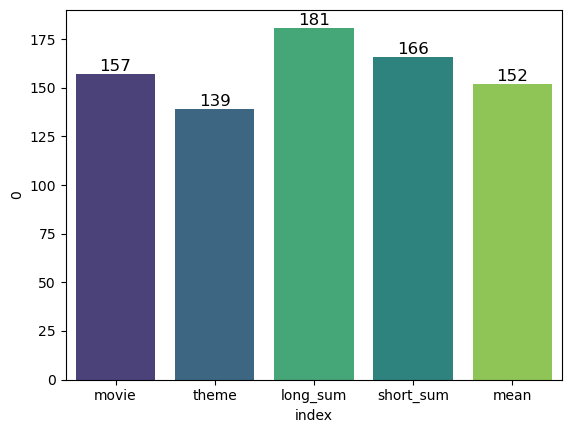

In [16]:
llm_match_summary = llm_match_summary.reset_index()
g = sns.barplot(llm_match_summary, x="index", y=0, hue="index", palette="viridis", order=["movie", "theme", "long_sum", "short_sum", "mean"])
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=12, color='black', ha='center', va='bottom')

In [17]:
final_concat_df = pd.concat(concat_dfs)
final_concat_df['query'] = final_concat_df['query'].map(long_queries)
final_concat_df.to_csv("movie_classifications.csv", index=False, header=True)
final_movie_df = pd.concat(movie_dfs)
final_theme_df = pd.concat(theme_dfs)
final_theme_group_short_df = pd.concat(theme_group_short_dfs)
final_theme_group_long_df = pd.concat(theme_group_long_dfs)
final_theme_group_mean_df = pd.concat(theme_group_mean_dfs)
final_retrieval_df = pd.concat([final_movie_df, final_theme_df, final_theme_group_short_df, final_theme_group_long_df, final_theme_group_mean_df])
final_retrieval_df.to_csv("movie_retrievals.csv", index=False, header=True)

# I reviewed the matches independently to see if I thought the results matched the intent of the query. 
Reread the CSV to get human matches.

In [18]:
human_matched_df = pd.read_csv("movie_classifications.csv")

In [19]:
human_matched_df.shape

(1242, 6)

In [20]:
final_retrieval_df['query'] = final_retrieval_df['query'].map(long_queries)

In [21]:
movie_retrievals_df = final_retrieval_df.merge(human_matched_df[["query", "tmdbId", "human_matches_theme"]], 
                                                on=["query", "tmdbId"], how="inner")
movie_retrievals_df['index']=movie_retrievals_df['index'].map({'movie':'movie', 'theme':'theme', 'theme_group_long': 'long_sum', 
                                                               'theme_group_short': 'short_sum',
                                                               'theme_group_mean': 'mean'})


In [24]:
movie_retrievals_df['matches_theme'] = movie_retrievals_df['matches_theme'].map({"no": "N", "yes": "Y"})

In [25]:
movie_retrievals_df.head()

,query,index,score,tmdbId,title,overview,map,matches_theme,theme,human_matches_theme
0,documentary about a painter,movie,0.741836,1174520,Watercolors,Watercolors is an omnibus documentary that hig...,"{'title': 'Watercolors', 'overview': 'Watercol...",N,NaN,N
1,documentary about a painter,movie,0.736931,1192768,Of Color & Ink,"The documentary that uncovers the creative, po...","{'title': 'Of Color & Ink', 'overview': 'The d...",Y,NaN,Y
2,documentary about a painter,movie,0.736722,999257,Ricardo and Painting,Ricardo and Painting is Barbet Schroeder's por...,"{'title': 'Ricardo and Painting', 'overview': ...",Y,NaN,Y
3,documentary about a painter,movie,0.736375,1203399,The Painting,A dying filmmaker decides to create a giant pa...,"{'title': 'The Painting', 'overview': 'A dying...",N,NaN,N
4,documentary about a painter,movie,0.734079,1199838,Painter,Painter finds half photo of a struggling dusky...,"{'title': 'Painter', 'overview': 'Painter find...",N,NaN,N


## How often did human and LLM agree about whether movie matched qeustion?

In [26]:
(movie_retrievals_df['matches_theme'] == movie_retrievals_df['human_matches_theme']).sum()

1820

In [28]:
movie_retrievals_df.shape

(2448, 10)

In [29]:
1820/2448

0.7434640522875817

# Summarize the number of human matched movies per query and index

In [31]:
movie_summary = movie_retrievals_df.groupby(['query', 'index'])['human_matches_theme'].value_counts().reset_index().pivot(columns="human_matches_theme", index=["query", "index"])

In [32]:
movie_summary = pd.DataFrame(movie_summary['count']['Y']).fillna(0).reset_index()

In [33]:
movie_summary

,query,index,Y
0,Europe in the 1960s,long_sum,17
1,Europe in the 1960s,mean,11
2,Europe in the 1960s,movie,11
3,Europe in the 1960s,short_sum,13
4,Europe in the 1960s,theme,11
5,baseball,long_sum,19
6,baseball,mean,15
7,baseball,movie,14
8,baseball,short_sum,18
9,baseball,theme,16


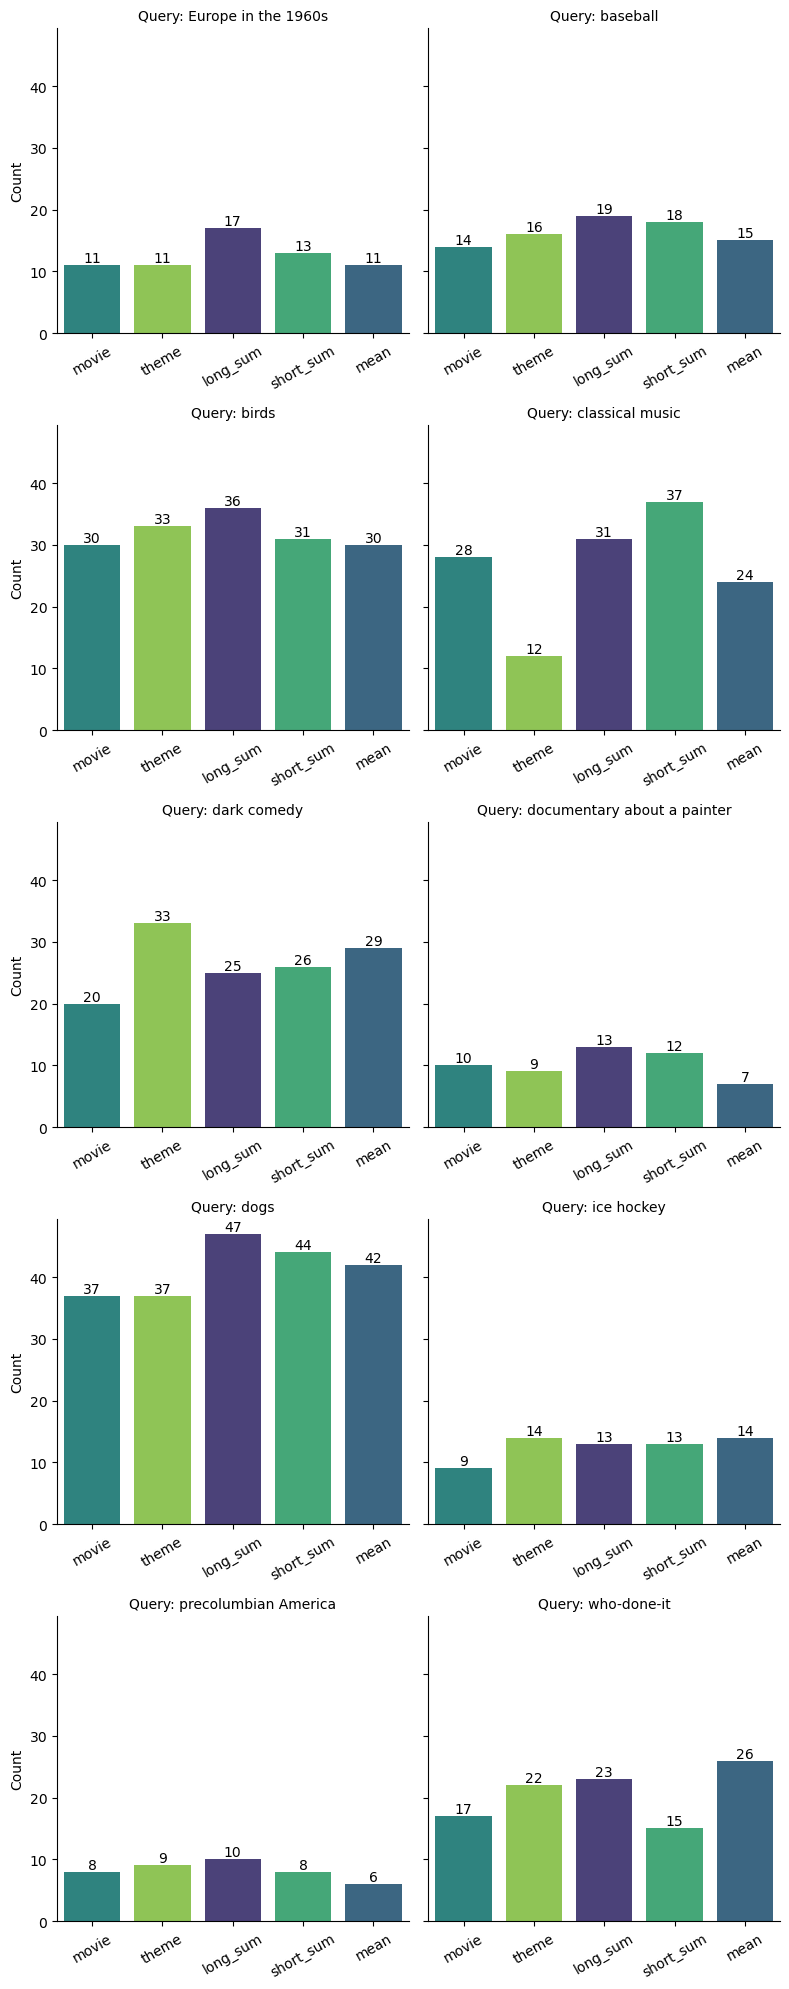

In [34]:
g = sns.FacetGrid(movie_summary, col="query", col_wrap=2, height=4, sharex=False)
g.map_dataframe(sns.barplot, x="index", y="Y", hue="index", palette="viridis", order=["movie", "theme", "long_sum", "short_sum", "mean"])
g.set_axis_labels("", "Count")  # Removed "Index" label

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=30)

# Display count values on each bar
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=10, color='black', ha='center', va='bottom')

# Set titles for each plot
g.set_titles("Query: {col_name}")

plt.tight_layout()
plt.show()

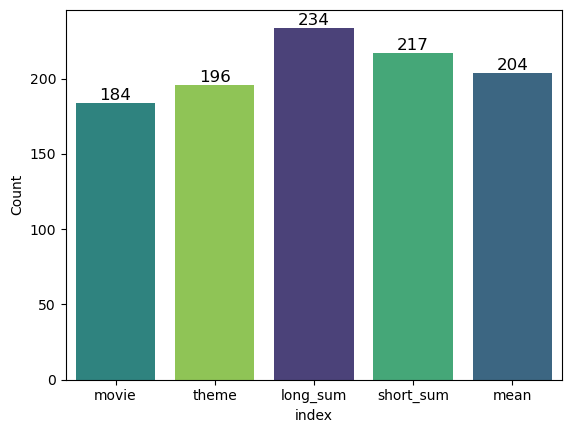

In [35]:
overall_summary = movie_summary.groupby("index")['Y'].sum().reset_index()
g = sns.barplot(overall_summary, x="index", y="Y", hue="index", palette="viridis", order=["movie", "theme", "long_sum", "short_sum", "mean"])
plt.ylabel("Count") 
for p in plt.gca().patches:
    plt.gca().text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=12, color='black', ha='center', va='bottom')


In [65]:
overall_summary

,index,Y
0,long_sum,234
1,mean,204
2,movie,184
3,short_sum,217
4,theme,196


# Examine individual themes that performed well or poorly on specific queries

In [39]:
def compare_matched_lists(query, index1, index2):
    set1 = set(movie_retrievals_df[(movie_retrievals_df['query'] == query) & (movie_retrievals_df['index']==index1) 
                                   & (movie_retrievals_df['human_matches_theme']=="Y") ]['title'].tolist())
    set2 = set(movie_retrievals_df[(movie_retrievals_df['query'] == query) & (movie_retrievals_df['index']==index2)
                                   & (movie_retrievals_df['human_matches_theme']=="Y")]['title'].tolist())
    both_indexes = set1.intersection(set2)
    only_index1 = set1.difference(set2)
    only_index2 = set2.difference(set1)
    return both_indexes, only_index1, only_index2

In [46]:
compare_matched_lists("classical music", "short_sum", "long_sum")

({'Als ik zelf de zon ben',
  'Asfalto che suona',
  'Beautiful Pleasant Trivial',
  'Crescendo',
  'Das Märchen von der Zauberflöte',
  'Film Fest Gent',
  'Goddess of Speed',
  "Horrible Histories: 'Orrible Opera",
  'IN THE BASEMENT OF APOLLO HALL',
  'Le Nozze Di Figaro - Opera Ballet Vlaanderen',
  "Mozart's Requiem",
  'My Favorite Things: The Rodgers & Hammerstein 80th Anniversary Concert',
  "My Name's Ben Folds – I Play Piano",
  'Poster Child',
  'Symphonic Sketches',
  'Symphony n. 9 by Ludwig van Beethoven in St. Mark’s Square',
  'The Orchestra Chuck Built'},
 {'Balto kuģu sirdis',
  'Cymbalaria',
  'Dulcineia',
  'Earworm',
  'Ethereal Cascades',
  'Fioretta',
  'Fire Dialogues',
  'Grand Finale',
  'Haunted Harmony Mysteries: Murder in G Major',
  'Life, Composed.',
  'Manu: A Visual Album',
  'Nocturne',
  'N’Importe Quoi (for Brunhild)',
  'Pioniere der Filmmusik - Europas Sound für Hollywood',
  'Shchedryk from Podillya',
  'Solo',
  'Stars',
  'The Only Girl in the O

In [66]:
compare_matched_lists("baseball", "movie", "long_sum")

({'101: The Story of the 2023 Baltimore Orioles',
  'Because They Believed',
  "Carson Bigbee: The Pirate of America's Pastime",
  'Indoor Baseball',
  'Kanashimi',
  'Monster Under The River',
  'Samurai Japan: The Story Behind the WBC Clean Sweep',
  'Shohei Ohtani: Beyond the Dream',
  'Smashing Pumpkins',
  'The Astros Edge',
  'The Many Worlds of George Goodman',
  'Thunder Rolls! The World of Blind Baseball',
  'Young Again',
  'unDEFILED'},
 set(),
 {'Consumed',
  'Heritage Minutes: Mary "Bonnie" Baker',
  'I Can',
  'Shame',
  'Swimming in a Sand Pool'})

In [48]:
compare_matched_lists("dark comedy", "theme", "long_sum")

({'Abomination',
  'Accessory',
  'Affirmations',
  'Barely Breathing',
  'Death Perception',
  'Dindin',
  'Double Trouble',
  'Død af grin',
  'End All, Say All',
  'Fishmonger',
  'Funny Not Funny',
  'Klokkenluider',
  'Mike Ward : Noir',
  'Otto Baxter: Not A F***ing Horror Story',
  'Should Be Long Gone',
  'Silence',
  'Sleepyhead',
  'Stand-Up - My Life Is A Joke',
  'Sweet Dreams',
  'The Choice Has Been Made',
  'The Martini Shot',
  'Triple Oh!'},
 {'Dare!',
  'Dead Serious',
  'Horny Teenagers Must Die!',
  'In Search Of...Detective Barnaby And His Descent Into The Haunted Mansion',
  'Paranormal Drunktivity',
  'Reverse Ketchup',
  'Shaky Shivers',
  'Strange Things Happen at the Weird House',
  'The Haunted Baby Carriage From Hell',
  'The Puppet Asylum',
  'The Treasure of the Cyclops'},
 {'Eppura', 'Night', 'The Dark House of Mystery'})

In [49]:
compare_matched_lists("Europe in the 1960s", "movie", "long_sum")

({'All Men Become Brothers',
  'Lady with Lipstick',
  'Sea-64',
  'Speak Sunlight',
  'Yesterday'},
 {'All Will Be Revealed',
  'Dream Time',
  'I’m Not Everything I Want To Be',
  'La Reine',
  'Motherland',
  'Nowhere'},
 {'A Lonely Voice Against Moscow',
  'All makt til ingen',
  'Burnt Flowers',
  'Child No. 182',
  'Dear Monster',
  'Der Funker',
  'Filhas da Pátria',
  'Holy Family',
  'Jokes & Cigarettes',
  'Lex Barker - Westernheld und Playboy',
  'Subject: Filmmaking',
  'The Man from Nowhere'})

In [50]:
compare_matched_lists("dogs", "movie", "long_sum")

({'A Dog Called Laura',
  'Au Revoir, Pugs',
  'Carlitos',
  'Carole & Grey',
  'Crate Dog',
  'Disc+Dog',
  'Dog Biscuits',
  'Dog Days',
  'Dogman',
  'Dogs at the Opera',
  'Frank and His Dogs',
  "Hey Duggee's Cinema Outing",
  "I'll Crush Y'all",
  "Life's a Bitch",
  'Little Death',
  'Love Death Dog',
  'Rain',
  'Small Exchanges, Great Destiny',
  'Thank You for Your Service',
  'The Company We Keep',
  'The Day of the Sun Dog',
  'The Heirloom',
  'The Reflection',
  'We Are All Dogs',
  'Wet Dogs'},
 {'Bad Dog',
  'Cat and Dog',
  'Christmas with the Pups',
  'Dog Movie',
  'Larry',
  'PAW Patrol: The Mighty Movie',
  'Robot Dreams',
  'Rocky Meets Lucy',
  'Snowy Dog',
  'The Chihuahua Shake',
  'The Collection'},
 {'AJ Goes to the Dog Park',
  'Arf',
  'City Strays',
  "Dad's Journal",
  'De kantoorhond',
  "Dolly Parton's Pet Gala",
  'Have A Good One',
  'High Tail',
  'Hold on for Dear Life',
  'I Was a Soldier',
  'Little Stray',
  'Mr. Pawsitively Perfect',
  'My Chris

Theme did a lot better on dark comedy that theme group. Theme picked up on horror-comedy and horror comedy themes that were bundled in with more generic horror topics in the theme groups.

In [67]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'dark comedy') 
                    & (movie_retrievals_df['human_matches_theme']=='N')
                    & movie_retrievals_df['index'].isin(['long_sum'])][['index','title', 'theme']]

,index,title,theme
1709,long_sum,Her Dark Reflection,[[dark journey]]
1713,long_sum,The Day Is Long and Dark,"[[dark themes, dark thoughts]]"
1715,long_sum,Pitch Black,[[Pitch Black]]
1718,long_sum,The Deep Dark,"[[Deep dark, dark]]"
1720,long_sum,A Dark Place,"[[dark abyss, dark house, dark place, dark roo..."
1722,long_sum,No Parpadees,"[[dark abyss, dark house, dark place, dark roo..."
1723,long_sum,Cold and Dark,"[[Deep dark, dark]]"
1725,long_sum,Fables for the Witching Hour,[[dark office]]
1726,long_sum,The Midnight Drive,"[[Deep dark, dark]]"
1727,long_sum,Descendants of the Dark,"[[Deep dark, dark]]"


In [68]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'dark comedy') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['theme', 'long_sum'])][['index','title', 'theme']]

,index,title,theme
750,theme,Silence,[dark comedy]
751,theme,"End All, Say All",[dark comedy]
752,theme,Affirmations,[dark comedy]
753,theme,Dindin,[dark comedy]
754,theme,Accessory,[dark comedy]
755,theme,Død af grin,[dark comedy]
756,theme,Death Perception,[dark comedy]
758,theme,Stand-Up - My Life Is A Joke,[dark comedy]
760,theme,Dead Serious,[romantic comedy]
761,theme,Sweet Dreams,[black comedy]


Theme group mean did very poorly on baseball. What themes was it matching on?

In [70]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'baseball') 
                    & (movie_retrievals_df['human_matches_theme']=='N')
                    & movie_retrievals_df['index'].isin(['mean'])][['index','title', 'theme']]

,index,title,theme
2114,mean,Mountainside,"[[Sexy movies, movies within movies, popular m..."
2115,mean,Trouble with Johnny,"[[Sexy movies, movies within movies, popular m..."
2116,mean,Love & Films,"[[Movie set, film school, film set, filmograph..."
2117,mean,The Hoop Dreams Holiday Special,[[Hoop Dreams]]
2118,mean,Against the Grain,"[[Genre films, classic cinema, concert film, c..."
2119,mean,The Busy World Around Me.,"[[Movie set, film school, film set, filmograph..."
2120,mean,Teams and Dreams: Spikeball 2023 College Natio...,"[[College Nationals, College baseball]]"
2122,mean,"Dans le Film, le Film des Films au Cinema Pour...","[[Movie set, film school, film set, filmograph..."
2123,mean,Blockbuster,"[[Genre films, classic cinema, concert film, c..."
2124,mean,Three Solar Exercises,"[[Movie set, film school, film set, filmograph..."


In [71]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'baseball') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['long_sum'])][['index','title', 'theme']]

,index,title,theme
1620,long_sum,Thunder Rolls! The World of Blind Baseball,[[Blind baseball]]
1621,long_sum,Young Again,"[[College Nationals, College baseball]]"
1622,long_sum,Shohei Ohtani: Beyond the Dream,"[[MLB stardom], [Shohei Ohtani]]"
1623,long_sum,Monster Under The River,"[[Baseball field, baseball, baseball cap]]"
1624,long_sum,Indoor Baseball,[[Indoor baseball]]
1625,long_sum,The Astros Edge,"[[baseball scandal], [modern MLB], [Astros]]"
1626,long_sum,unDEFILED,"[[Baseball field, baseball, baseball cap]]"
1627,long_sum,Carson Bigbee: The Pirate of America's Pastime,"[[Baseball field, baseball, baseball cap], [Wo..."
1628,long_sum,Kanashimi,[[baseball glove]]
1629,long_sum,Samurai Japan: The Story Behind the WBC Clean ...,"[[Baseball field, baseball, baseball cap]]"


Short sum did a lot better than theme for classical music. What themes did short sum pick up that theme missed?

In [72]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'classical music') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['short_sum'])][['index','title', 'theme']]

,index,title,theme
1050,short_sum,Beautiful Pleasant Trivial,"[[anti-classical, classical], [musical works]]"
1051,short_sum,Pioniere der Filmmusik - Europas Sound für Hol...,[[Film music]]
1052,short_sum,Symphonic Sketches,"[[classical music], [orchestra performance]]"
1053,short_sum,Poster Child,[[Prestigious orchestra]]
1054,short_sum,IN THE BASEMENT OF APOLLO HALL,"[[composer, composers]]"
1055,short_sum,Film Fest Gent,"[[composer, composers]]"
1056,short_sum,Asfalto che suona,"[[anti-classical, classical]]"
1057,short_sum,Horrible Histories: 'Orrible Opera,[[Mozart]]
1058,short_sum,The Piper,"[[composer, composers]]"
1059,short_sum,Crescendo,[[classical music]]


In [74]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'classical music') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['theme'])][['index','title', 'theme']]

,index,title,theme
550,theme,Beautiful Pleasant Trivial,"[musical works, classical]"
551,theme,Pioniere der Filmmusik - Europas Sound für Hol...,[Film music]
552,theme,Symphonic Sketches,[classical music]
553,theme,Music Genres. Voices of the World,[classics]
554,theme,Asfalto che suona,[anti-classical]
556,theme,Sergey Slonimsky. Bells,[musical]
557,theme,Crescendo,[classical music]
561,theme,Symphony n. 9 by Ludwig van Beethoven in St. M...,[classical music]
564,theme,"Marta, la musical. Una ópera de Dani Umpi.",[musical]
567,theme,Als ik zelf de zon ben,[classical music]


In [75]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'classical music') 
                    & (movie_retrievals_df['human_matches_theme']=='N')
                    & movie_retrievals_df['index'].isin(['theme'])][['index','title', 'theme']]

,index,title,theme
555,theme,Why Movies?,[movies]
558,theme,Música!,[Music school]
559,theme,berlinmusik,[Symphonies]
560,theme,Show Tunes at the BBC,[The Sound of Music]
562,theme,Against the Grain,[Genre films]
563,theme,Love & Films,[films]
565,theme,Materia vibrante,[silent symphony]
566,theme,BACKSTAGE: The Movie,[musical]
568,theme,Watercolors,[musical world]
569,theme,Maya! The Musical,[musical]


In [77]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'classical music') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['mean'])][['index','title', 'theme']]

,index,title,theme
2004,mean,Beautiful Pleasant Trivial,"[[musical works], [anti-classical, classical]]"
2005,mean,Pioniere der Filmmusik - Europas Sound für Hol...,[[Film music]]
2007,mean,Symphonic Sketches,[[classical music]]
2008,mean,The Musical Mind: A Portrait in Process,"[[Musical gift, musical cat, musical genius, m..."
2009,mean,Fantasymphony II - A Concert of Fire and Magic,"[[Choral symphony, Symphonic, Symphonic Odysse..."
2010,mean,Music Genres. Voices of the World,"[[Musical documentary, music, music performanc..."
2012,mean,Doraemon the Movie: Nobita's Earth Symphony,"[[Musical documentary, music, music performanc..."
2013,mean,IN THE BASEMENT OF APOLLO HALL,"[[Musical documentary, music, music performanc..."
2014,mean,Film Fest Gent,"[[Musical documentary, music, music performanc..."
2015,mean,Asfalto che suona,"[[anti-classical, classical]]"


In [78]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'classical music') 
                    & (movie_retrievals_df['human_matches_theme']=='N')
                    & movie_retrievals_df['index'].isin(['mean'])][['index','title', 'theme']]

,index,title,theme
2006,mean,I Hear a Symphony,"[[Musical documentary, music, music performanc..."
2011,mean,Songs from the Hole,"[[Musical documentary, music, music performanc..."
2016,mean,Nosferatu: A Symphony of Horror,"[[Choral symphony, Symphonic, Symphonic Odysse..."
2017,mean,Istanbul Trilogy: Music,"[[Musical documentary, music, music performanc..."
2018,mean,Reminder,"[[Musical documentary, music, music performanc..."
2020,mean,Planet Maximus,"[[Musical documentary, music, music performanc..."
2022,mean,One For My Baby,"[[Musical documentary, music, music performanc..."
2023,mean,berlinmusik,"[[Choral symphony, Symphonic, Symphonic Odysse..."
2029,mean,نجميّات,"[[Musical documentary, music, music performanc..."
2030,mean,Thin Rain,"[[Choral symphony, Symphonic, Symphonic Odysse..."


Long sum did really well at dogs. What themes did it use?

In [79]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'dogs') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['long_sum'])][['index','title', 'theme']]

,index,title,theme
1904,long_sum,Dogman,"[[stray dog, stray dogs, street dog, street ki..."
1905,long_sum,Dog Days,"[[dog, dogs]]"
1906,long_sum,The Heirloom,[[Rescue dog]]
1907,long_sum,Dog Days,[[pet ownership]]
1908,long_sum,We Are All Dogs,"[[dog, dogs]]"
1909,long_sum,Little Death,[[Small dog]]
1910,long_sum,Life's a Bitch,"[[Human-dog relationships], [Chihuahua]]"
1911,long_sum,Wet Dogs,[[Wet dogs]]
1912,long_sum,Dogs at the Opera,"[[stray dog, stray dogs, street dog, street ki..."
1913,long_sum,Love Death Dog,"[[dog, dogs]]"


Looks like theme found "dogs," but missed "dog."

In [81]:
movie_retrievals_df[(movie_retrievals_df['query'] == 'dogs') 
                    & (movie_retrievals_df['human_matches_theme']=='Y')
                    & movie_retrievals_df['index'].isin(['theme'])][['index','title', 'theme']]

,index,title,theme
950,theme,Dogman,[stray dogs]
951,theme,Dog Days,[dogs]
952,theme,The Heirloom,[Rescue dog]
953,theme,We Are All Dogs,[dogs]
954,theme,Little Death,[Small dog]
955,theme,Life's a Bitch,[Human-dog relationships]
956,theme,Wet Dogs,[Wet dogs]
957,theme,Dogs at the Opera,[stray dogs]
958,theme,Love Death Dog,[dogs]
959,theme,A Dog Called Laura,[dogs]
